# Bài toán

Trong notebook này, chúng ta sẽ ứng dụng thuật toán hồi quy tuyến tính mà chúng ta đã học trong khóa học này.

Hãy đọc dữ liệu bằng thư viện Pandas, sau đó sử dụng thuật toán hồi quy tuyến tính với các đặc trưng khác nhau nhằm tìm ra thuật toán hồi quy tuyến tính tốt nhất thông qua phương pháp đánh giá độ chính xác.

Tập dữ liệu và bài toán thuộc dạng hồi quy cổ điển. Với một số đặc trưng nhất định, chúng ta cần xây dựng một mô hình hồi quy tuyến tính để xác định **số lượng hồ sơ được chấp nhận** dựa vào các đặc trưng đã có.

Để giải quyết bài toán này, chúng ta cần phân tích dữ liệu, thực hiện bất kỳ chuyển đổi và chuẩn hóa cần thiết nào, áp dụng thuật toán ML, huấn luyện mô hình, kiểm tra chất lượng của mô hình đã huấn luyện và lặp lại cho đến khi có được chất lượng cao nhất cho tập dữ liệu của mình.

# Pipeline

1. Đọc dữ liệu.

2. Tiền xử lý dữ liệu.

3. Trực quan dữ liệu.

4. Chuẩn bị dữ liệu.

5. Xây dựng mô hình hồi quy tuyến tính đơn biến.

6. Xây dựng mô hình hồi quy tuyến tính đa biến.

7. Xây dựng mô hình hồi quy tuyến tính trên toàn bộ đặc trưng để quan sát mối quan hệ giữa các đặc trưng và mục tiêu.

8. Xây dựng mô hình Lasso để lựa chọn đặc trưng tốt nhất cho mục tiêu.

# Tập dữ liệu

Dự án này liên quan đến tập dữ liệu College, trong file [College.csv](https://drive.google.com/file/d/167ysw5-Bf15_Gm_aiePZfrS3fBWWfJVl/view) trong thư mục dữ liệu. Nó chứa các biến sau cho 777 trường đại học và cao đẳng khác nhau ở Mỹ:

**Private**: Chỉ báo public/private

**Apps**: Số lượng hồ sơ nhận được

**Accept**: Số lượng sinh viên được chấp thuận

**Enroll**: Số sinh viên mới đăng ký

**Top10perc**: Sinh viên mới từ top 10% lớp trung học

**Top25perc**: Sinh viên mới từ top 25% lớp trung học

**F.Undergrad**: Số sinh viên đại học toàn thời gian

**P.Undergrad**: Số sinh viên đại học bán thời gian

**Outstate**: Học phí ngoại bang

**Room.Board**: Chi phí ăn ở

**Books**: Chi phí giáo trình theo ước tính

**Personal**: Chi tiêu cá nhân theo ước tính

**PhD**: Phần trăm giảng viên có bằng Tiến sĩ

**Terminal**: Phần trăm giảng viên có Terminal degree (bẳng cấp cao nhất trong một lĩnh vực nhất định)

**S.F.Ratio**: Tỷ lệ sinh viên/giảng viên

**perc.alumni**: Phần trăm cựu sinh viên đã quyên góp

**Expend**: Chi phí giảng dạy cho mỗi sinh viên

**Grad.Rate**: Tỷ lệ tốt nghiệp

# Thư viện cần thiết

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.style.use('ggplot')

# Hàm tiện ích

Phương pháp tiện ích này sẽ giúp vẽ biểu đồ các quan sát thử nghiệm của bạn, so sánh chúng với đường hồi quy và hiển thị hệ số R2.

In [3]:
def drawLine(model, X_test, y_test, title):
	# Hàm vẽ biểu đồ hồi quy khi X_test có 1 đặc trưng
	# và hiển thị hệ số R2
	y_pred = model.predict(X_test)

	fig = plt.figure()
	ax = fig.add_subplot(111)
	ax.scatter(X_test, y_test, c = 'g', marker = 'o')
	ax.plot(X_test, y_pred, color = 'orange', linewidth = 1, alpha = 0.7)
	ax.set_xlabel(title)
	ax.set_ylabel('Accept')

	R2 = r2_score(y_test, y_pred)

	ax.set_title(title)
	print("R2: " + str(R2))
	print("Intercept(s): ", model.intercept_)

	plt.show()

In [4]:
def drawPlane(model, X_test, y_test, title):
	# Hàm vẽ biểu đồ hồi quy khi X_test có 2 đặc trưng
	# và hiển thị hệ số R2
	fig = plt.figure()
	ax = fig.add_subplot(projection = '3d')
	ax.set_zlabel('prediction')

	# Chuyển về numpy vì X_test có thể là DataFrame, v.v.
	X_test = np.array(X_test)
	col1 = X_test[:, 0]
	col2 = X_test[:, 1]

	# Lấy giá trị nhỏ nhất và lớn nhất của 2 đặc trưng
	# để vẽ siêu mặt phẳng
	# do điểm nhỏ nhất và lớn nhất sẽ bao bọc toàn bộ dữ liệu
	x_min, x_max = col1.min(), col1.max()
	y_min, y_max = col2.min(), col2.max()
	x = np.arange(x_min, x_max, (x_max - x_min) / 10)
	y = np.arange(y_min, y_max, (y_max - y_min) / 10)
	x, y = np.meshgrid(x, y)

	# Dự đoán để lấy siêu mặt phẳng
	z = model.predict(np.c_[x.ravel(), y.ravel()])
	z = z.reshape(x.shape)

	# Trực quan hóa dữ liệu và vẽ siêu mặt phẳng
	ax.scatter(col1, col2, y_test, c = 'g', marker = 'o')
	ax.plot_wireframe(x, y, z, color = 'orange', alpha = 0.7)

	y_pred = model.predict(X_test)
	R2 = r2_score(y_test, y_pred)

	ax.set_title(title)
	print("R2: " + str(R2))
	print("Intercept(s): ", model.intercept_)

	plt.show()

# Task 1: Đọc dữ liệu từ tập dữ liệu College

Chỉ mục là cột tên trường đại học.

In [6]:
# Nhập code của bạn ở đây
df = pd.read_csv("College.csv")

college_df = df.rename(columns = {"Unnamed: 0": "CollegeName"}).set_index("CollegeName")
df.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


# Task 2: Mã hóa hạng mục

Sử dụng map() để chuyển đổi cột Private thành {'Yes':1, 'No':0}.

Hầu hết tất cả thuật toán học máy đều không làm việc với dữ liệu chuỗi hoặc hạng mục, do đó cần chuyển đổi những loại dữ liệu này để phù hợp với đầu vào của học máy. Phương thức `.map()` giống như `.apply()`, nhưng thay vì sử dụng lambda/function, bạn chỉ cần cung cấp ánh xạ key:value.

In [7]:
# Nhập code của bạn ở đây

def convert_value_private(s: str) -> int:
	if s == "Yes":
		return 1
	elif s == "No":
		return 0
	else:
		return 0


college_df["Private"] = college_df["Private"].map(lambda x: convert_value_private(x))


In [8]:
college_df

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
CollegeName,,,,,,,,,,,,,,,,,,
Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Worcester State College,0,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
Xavier University,1,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
Xavier University of Louisiana,1,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49


# Task 3: Trực quan ma trận tương quan

Tính toán ma trận trực quan từ DataFrame

In [8]:
# Nhập code của bạn ở đây
correlation_matrix = college_df.corr()

Trực quan ma trận trực quan bằng Seaborn

Text(0.5, 1.0, 'Correlation Matrix')

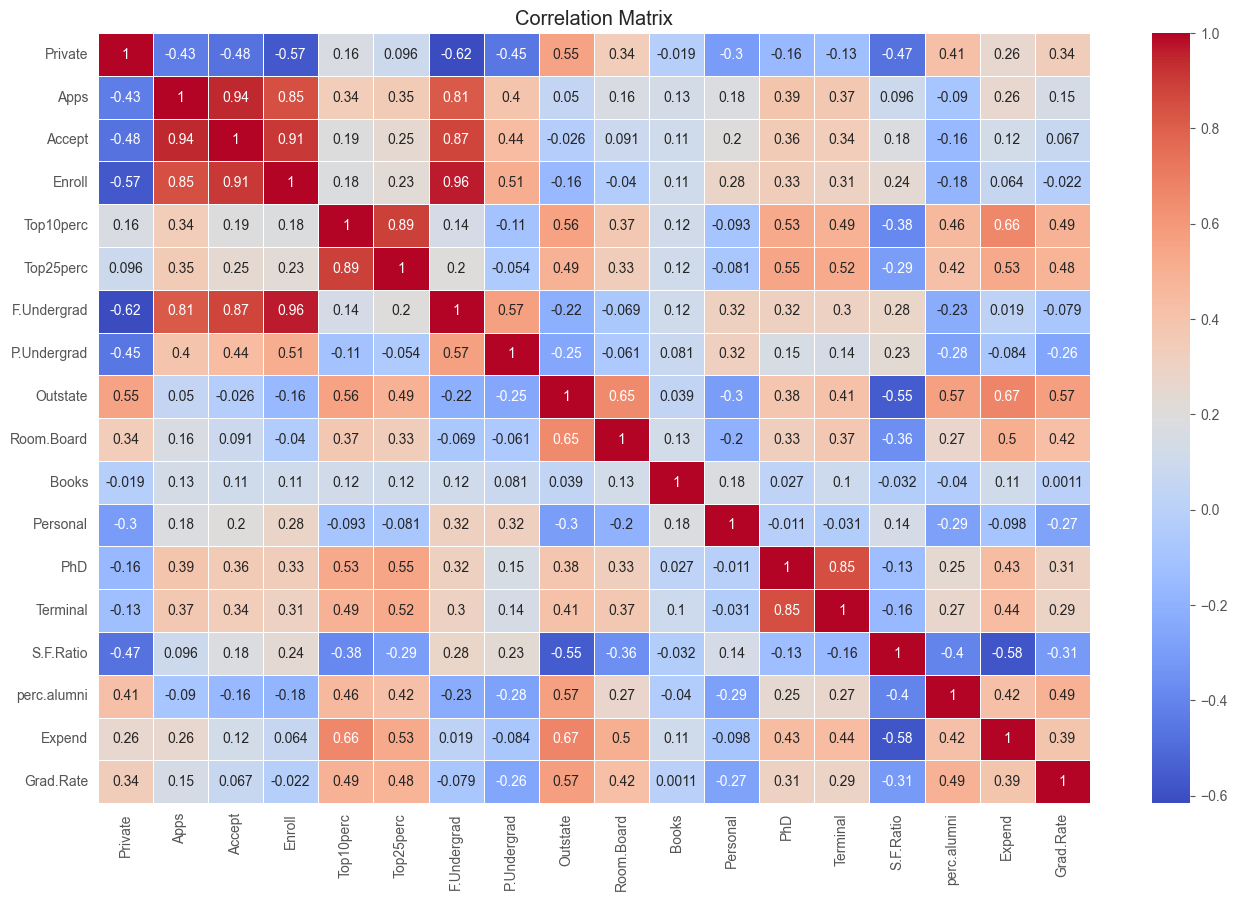

In [9]:
# Nhập code của bạn ở đây
plt.figure(figsize = (16, 10))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", linewidths = 0.5)
plt.title('Correlation Matrix')

# Task 4: Vẽ biểu đồ Scatter từng đặc trưng với mục tiêu

Lấy ra toàn bộ đặc trưng từ dữ liệu và loại bỏ đi mục tiêu ("Accept")

In [10]:
# Nhập code của bạn ở đây
target = "Accept"
college_without_accept_df = college_df[college_df.columns.difference([target])]
college_accept_df = college_df[target]
college_without_accept_df

,Apps,Books,Enroll,Expend,F.Undergrad,Grad.Rate,Outstate,P.Undergrad,Personal,PhD,Private,Room.Board,S.F.Ratio,Terminal,Top10perc,Top25perc,perc.alumni
CollegeName,,,,,,,,,,,,,,,,,
Abilene Christian University,1660,450,721,7041,2885,60,7440,537,2200,70,1,3300,18.1,78,23,52,12
Adelphi University,2186,750,512,10527,2683,56,12280,1227,1500,29,1,6450,12.2,30,16,29,16
Adrian College,1428,400,336,8735,1036,54,11250,99,1165,53,1,3750,12.9,66,22,50,30
Agnes Scott College,417,450,137,19016,510,59,12960,63,875,92,1,5450,7.7,97,60,89,37
Alaska Pacific University,193,800,55,10922,249,15,7560,869,1500,76,1,4120,11.9,72,16,44,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Worcester State College,2197,500,543,4469,3089,40,6797,2029,1200,60,0,3900,21.0,60,4,26,14
Xavier University,1959,600,695,9189,2849,83,11520,1107,1250,73,1,4960,13.3,75,24,47,31
Xavier University of Louisiana,2097,617,695,8323,2793,49,6900,166,781,67,1,4200,14.4,75,34,61,20


In [12]:
college_without_accept_df.columns.values

array(['Apps', 'Books', 'Enroll', 'Expend', 'F.Undergrad', 'Grad.Rate',
       'Outstate', 'P.Undergrad', 'Personal', 'PhD', 'Private',
       'Room.Board', 'S.F.Ratio', 'Terminal', 'Top10perc', 'Top25perc',
       'perc.alumni'], dtype=object)

Trực quan từng đặc trưng với mục tiêu

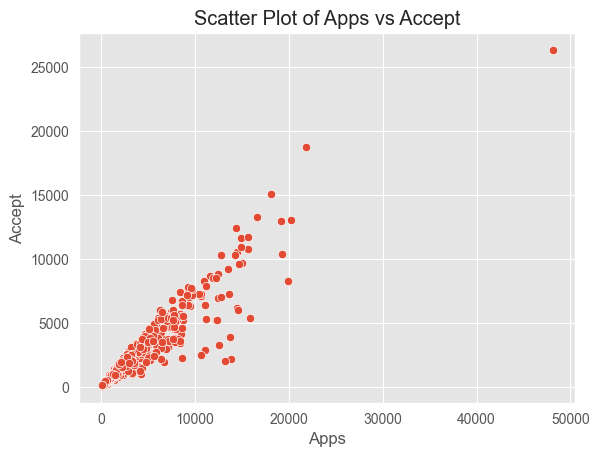

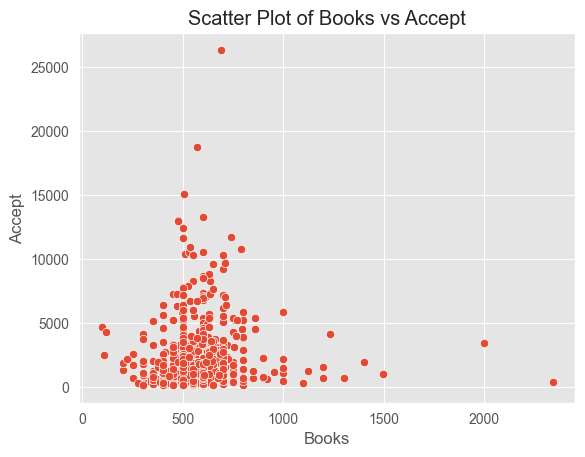

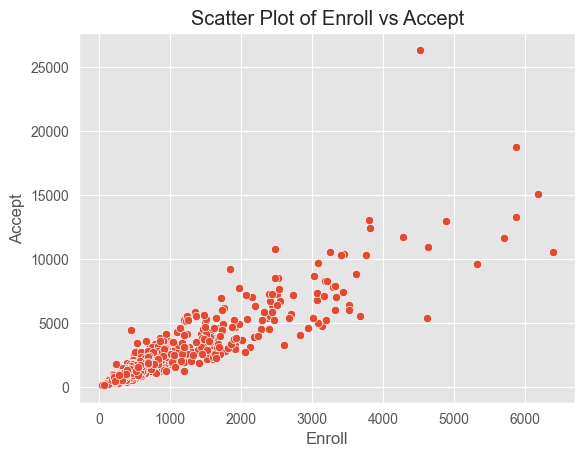

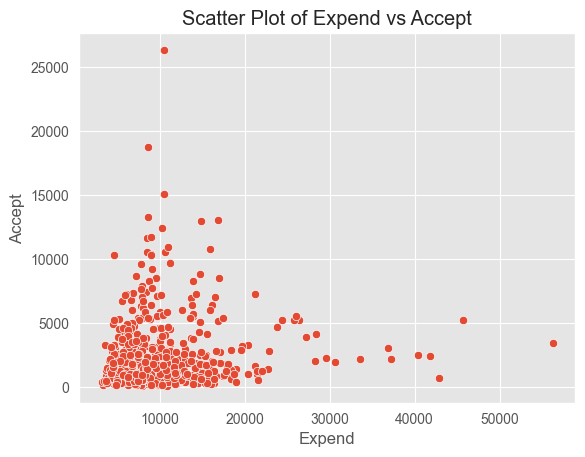

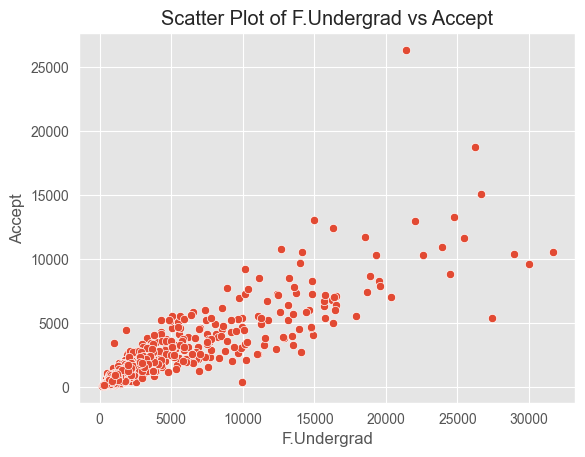

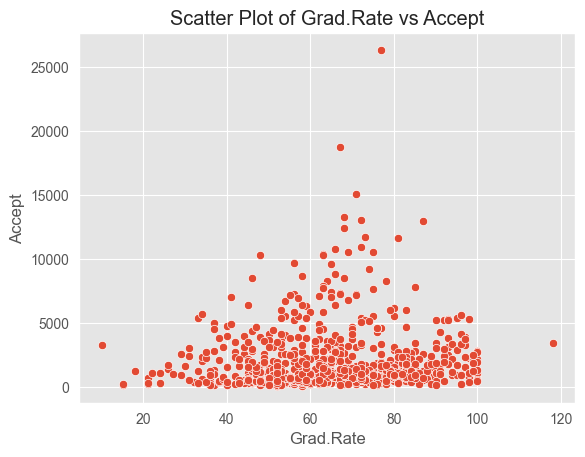

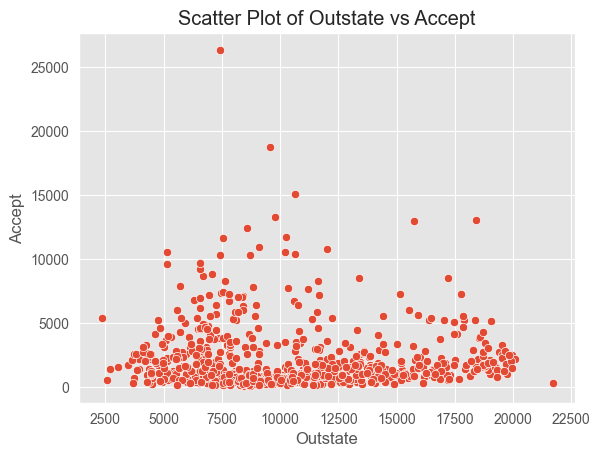

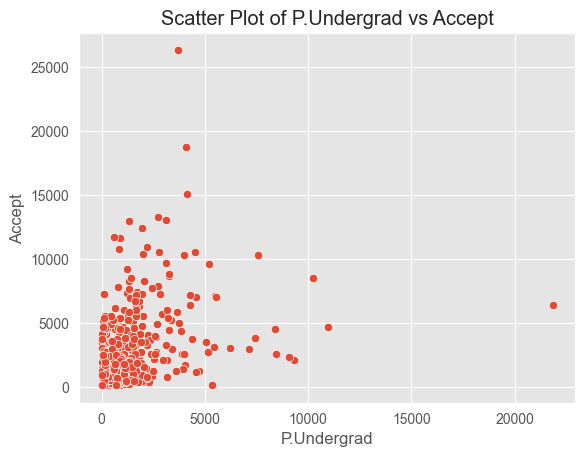

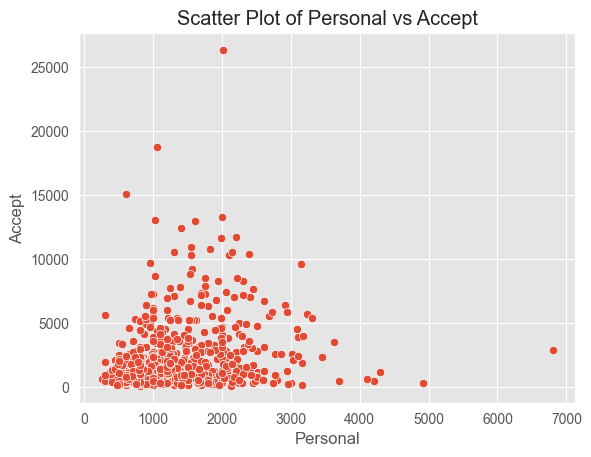

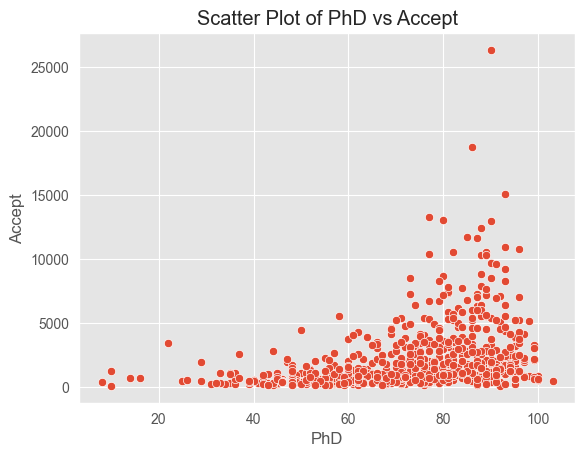

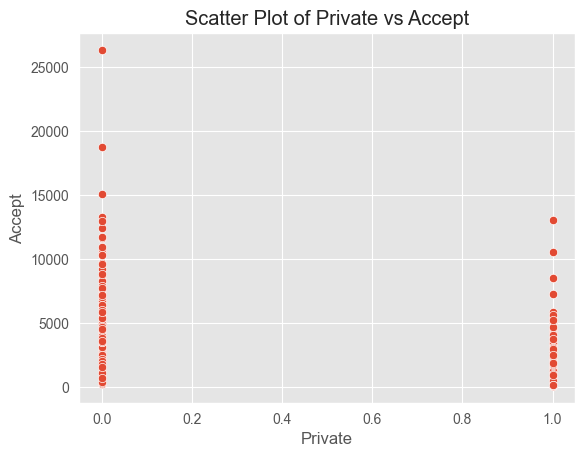

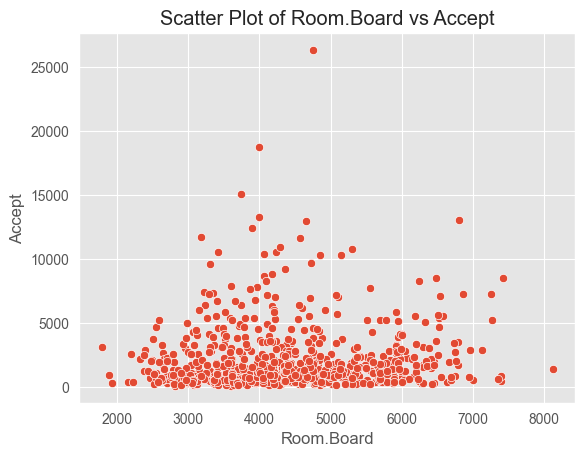

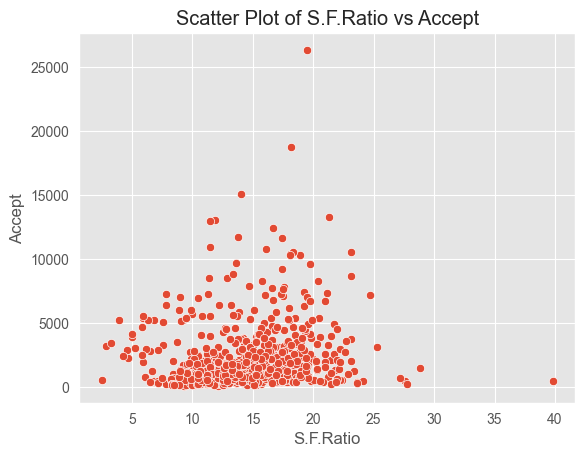

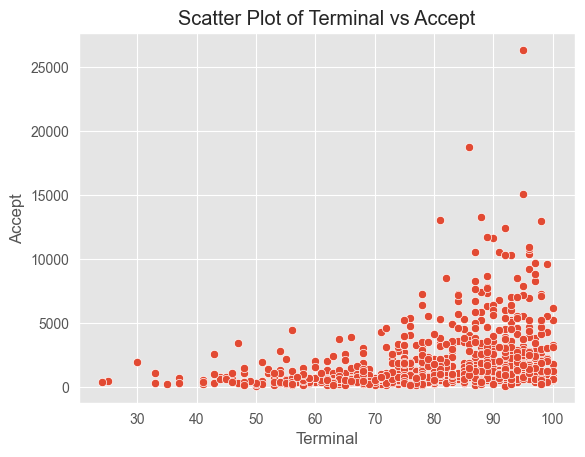

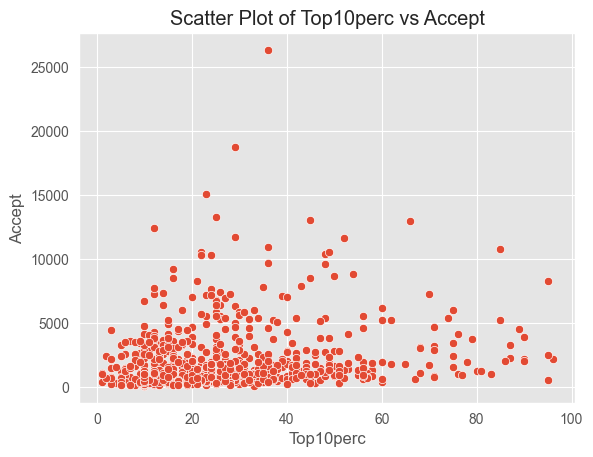

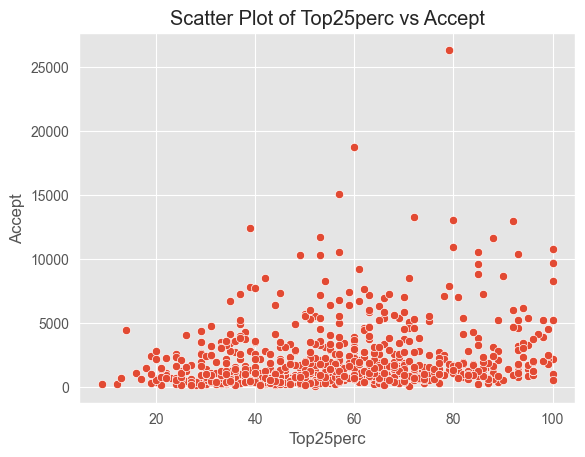

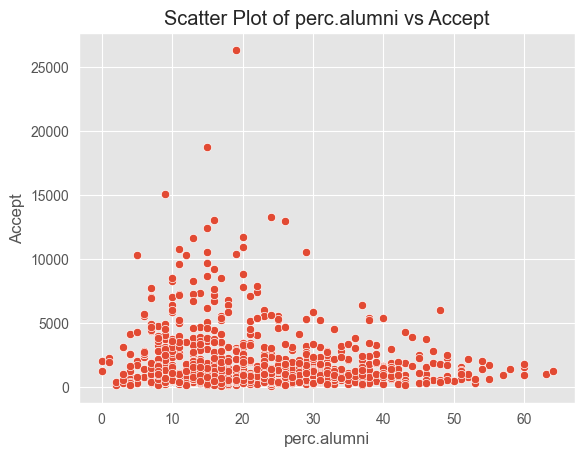

In [11]:
# Nhập code của bạn ở đây
features = college_without_accept_df.columns.values
for i, feature in enumerate(features):
	plt.subplot(1, 1, 1)
	sns.scatterplot(x = college_without_accept_df[feature], y = college_accept_df)
	plt.title(f'Scatter Plot of {feature} vs {target}')
	plt.xlabel(feature)
	plt.ylabel(target)
	plt.show()



# Task 5: Phân tách dữ liệu đặc trưng vào X, dữ liệu mục tiêu vào y từ dữ liệu gốc


In [12]:
# Nhập code của bạn ở đây
X = college_df[college_df.columns.difference([target])]
y = college_df[target]


In [13]:
X.head()

,Apps,Books,Enroll,Expend,F.Undergrad,Grad.Rate,Outstate,P.Undergrad,Personal,PhD,Private,Room.Board,S.F.Ratio,Terminal,Top10perc,Top25perc,perc.alumni
CollegeName,,,,,,,,,,,,,,,,,
Abilene Christian University,1660,450,721,7041,2885,60,7440,537,2200,70,1,3300,18.1,78,23,52,12
Adelphi University,2186,750,512,10527,2683,56,12280,1227,1500,29,1,6450,12.2,30,16,29,16
Adrian College,1428,400,336,8735,1036,54,11250,99,1165,53,1,3750,12.9,66,22,50,30
Agnes Scott College,417,450,137,19016,510,59,12960,63,875,92,1,5450,7.7,97,60,89,37
Alaska Pacific University,193,800,55,10922,249,15,7560,869,1500,76,1,4120,11.9,72,16,44,2


In [14]:
y.head()

CollegeName
Abilene Christian University    1232
Adelphi University              1924
Adrian College                  1097
Agnes Scott College              349
Alaska Pacific University        146
Name: Accept, dtype: int64

# Task 6: Tách dữ liệu thành train/test data

Dữ liệu train chiếm 70% và random_state là 7.

In [15]:
from sklearn.model_selection import train_test_split

# Nhập code của bạn ở đây
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 7)
X_train, X_test, y_train, y_test

(                                          Apps  Books  Enroll  Expend  \
 CollegeName                                                             
 University of Missouri at Saint Louis     1618    500     479    6433   
 Eastern Illinois University               5597    120    1565    5682   
 Eckerd College                            1422    600     366   15003   
 New Mexico Institute of Mining and Tech.   787    600     233    9241   
 Shippensburg University of Penn.          5818    450    1116    6719   
 ...                                        ...    ...     ...     ...   
 Taylor University                         1769    450     437    8294   
 Saint Olaf College                        2248    550     745   12502   
 Southwest State University                1047    600     511    6591   
 Fairfield University                      4784    700     781   11220   
 Earlham College                           1358    600     274   14634   
 
                                    

# Task 7: Mô hình hóa hồi quy tuyến tính chi phí ăn ở và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu chi phí ăn ở từ bộ train và test

In [39]:
# Nhập code của bạn ở đây
X_room_board = X['Room.Board']
X_train_rb, X_test_rb, y_train_rb, y_test_rb = train_test_split(X_room_board, y, test_size = 0.7, random_state = 7)
X_train_rb, X_test_rb, y_train_rb, y_test_rb

(CollegeName
 University of Missouri at Saint Louis       3964
 Eastern Illinois University                 3066
 Eckerd College                              4080
 New Mexico Institute of Mining and Tech.    3214
 Shippensburg University of Penn.            3504
                                             ... 
 Taylor University                           4000
 Saint Olaf College                          3750
 Southwest State University                  2750
 Fairfield University                        6200
 Earlham College                             4056
 Name: Room.Board, Length: 233, dtype: int64,
 CollegeName
 Westminster College                  3615
 North Central College                7398
 Dominican College of Blauvelt        5500
 Baldwin-Wallace College              4410
 SUNY College at Geneseo              4170
                                      ... 
 Indiana University at Bloomington    3990
 Ohio Wesleyan University             5650
 University of Utah               

Điều chỉnh shape dữ liệu phù hợp với đầu vào của mô hình

Mô hình hồi quy tuyến tính yêu cầu đầu vào có dạng là (m, n) với X và (m, 1) với y.

Trong đó:

- m là số lượng mẫu quan sát

- n là số lượng đặc trưng

Với một đặc trưng duy nhất, shape phù hợp sẽ là (m, 1) cho X.

In [40]:
# Nhập code của bạn ở đây

X_train_rb = np.array(X_train_rb).reshape(-1, 1)
X_test_rb = np.array(X_test_rb).reshape(-1, 1)
y_train_rb = np.array(y_train_rb).reshape(-1, 1)
y_test_rb = np.array(y_test_rb).reshape(-1, 1)


Xây dựng và huấn luyện mô hình

In [41]:
# Nhập code của bạn ở đây
model = LinearRegression()
model.fit(X_train_rb, y_train_rb)


LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [42]:
# Nhập code của bạn ở đây
y_pred_rb = model.predict(y_test_rb)
print("R2-score: %.2f" % r2_score(y_test_rb, y_pred_rb))

R2-score: 0.13


Trực quan mô hình hóa với dữ liệu test

R2: 0.0006721095230551866
Intercept(s):  [1994.67806396]


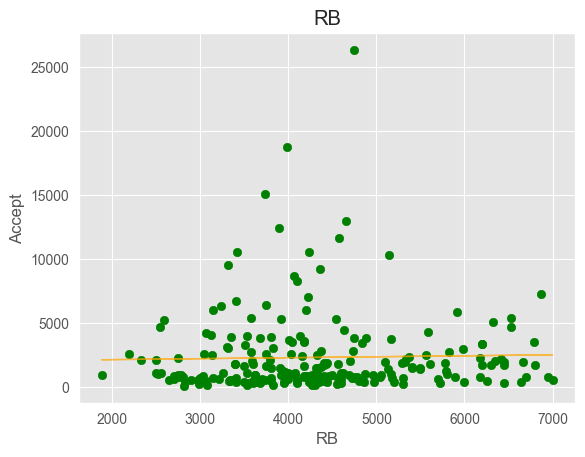

In [43]:
# Nhập code của bạn ở đây
drawLine(model, X_train_rb, y_train_rb, "RB")

# Task 8: Mô hình hóa hồi quy tuyến tính số lượng sinh viên ghi danh cho mỗi trường đại học và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học ở từ bộ train và test

In [59]:
# Nhập code của bạn ở đây
X_enroll = X['Enroll']
X_train_er, X_test_er, y_train_er, y_test_er = train_test_split(X_enroll, y, test_size = 0.7, random_state = 7)
X_train_er, X_test_er, y_train_er, y_test_er

(CollegeName
 University of Missouri at Saint Louis        479
 Eastern Illinois University                 1565
 Eckerd College                               366
 New Mexico Institute of Mining and Tech.     233
 Shippensburg University of Penn.            1116
                                             ... 
 Taylor University                            437
 Saint Olaf College                           745
 Southwest State University                   511
 Fairfield University                         781
 Earlham College                              274
 Name: Enroll, Length: 233, dtype: int64,
 CollegeName
 Westminster College                   377
 North Central College                 308
 Dominican College of Blauvelt         108
 Baldwin-Wallace College               662
 SUNY College at Geneseo              1143
                                      ... 
 Indiana University at Bloomington    5873
 Ohio Wesleyan University              458
 University of Utah                   

Điều chỉnh shape phù hợp với đầu vào của mô hình

In [60]:
# Nhập code của bạn ở đây
X_train_er = np.array(X_train_er).reshape(-1, 1)
X_test_er = np.array(X_test_er).reshape(-1, 1)
y_train_er = np.array(y_train_er).reshape(-1, 1)
y_test_er = np.array(y_test_er).reshape(-1, 1)

Xây dựng và huấn luyện mô hình

In [61]:
# Nhập code của bạn ở đây
model = LinearRegression()
model.fit(X_train_er, y_train_er)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [65]:
# Nhập code của bạn ở đây
y_pred_er = model.predict(X_test_er)
print("R2-score: %.2f" % r2_score(y_test_er, y_pred_er))

R2-score: 0.87


R2: 0.8746116882084188
Intercept(s):  [171.75035285]


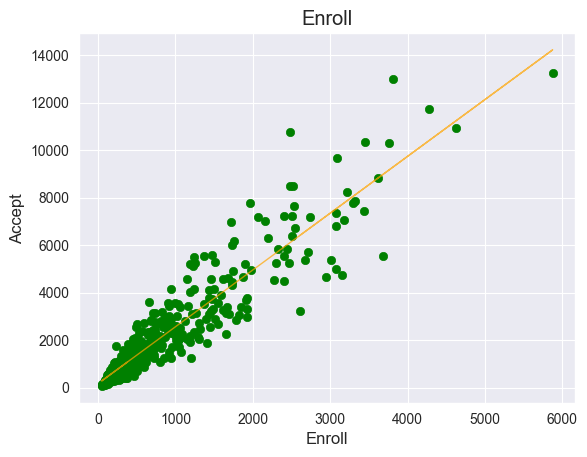

In [66]:
drawLine(model, X_test_er, y_test_er, "Enroll")

Trực quan mô hình với dữ liệu test

# Task 9: Mô hình hóa hồi quy tuyến tính từng đặc trưng với số lượng sinh viên được chấp nhận và trực quan hóa mô hình với dữ liệu test

Lưu ý: Sử dụng vòng lặp

R2: 0.8240807527193619
Intercept(s):  [198.7427944]


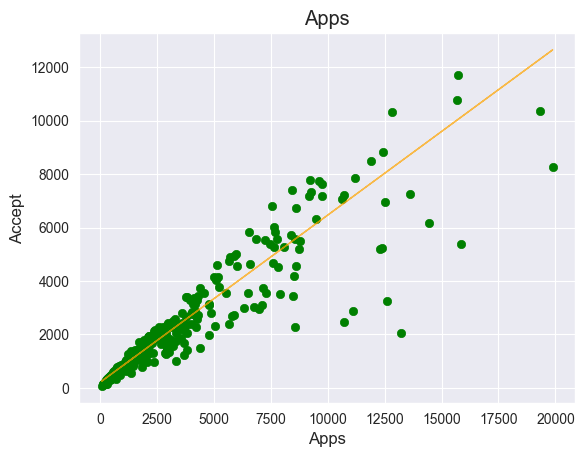

R2: 0.01690336586332708
Intercept(s):  [1382.52021415]


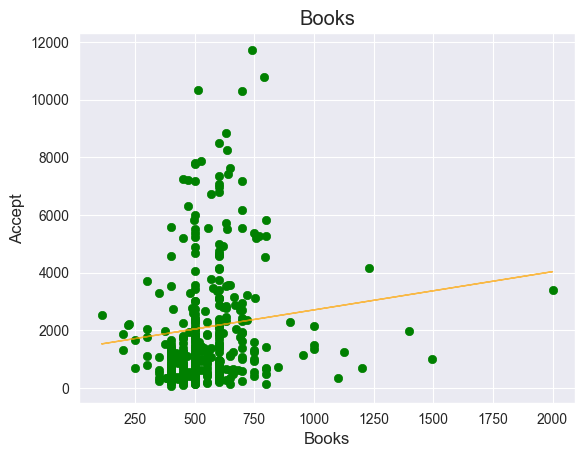

R2: 0.867616550693018
Intercept(s):  [143.54182526]


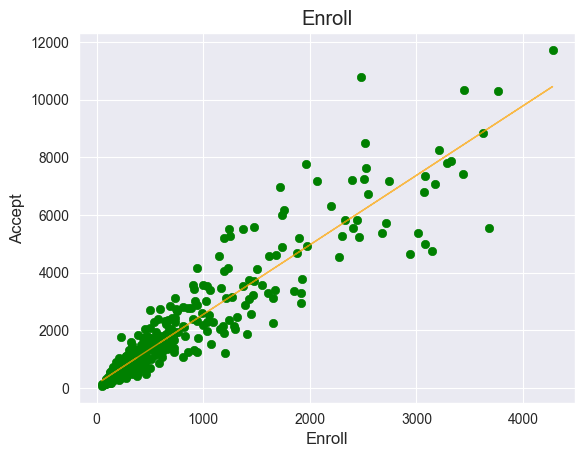

R2: 0.005436265347578573
Intercept(s):  [1394.08491206]


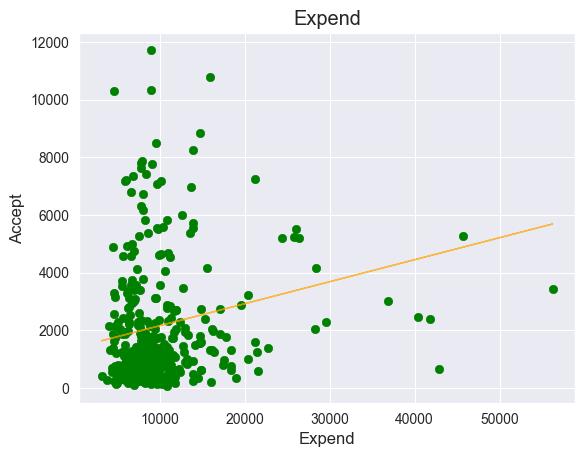

R2: 0.7955209897719346
Intercept(s):  [331.33549491]


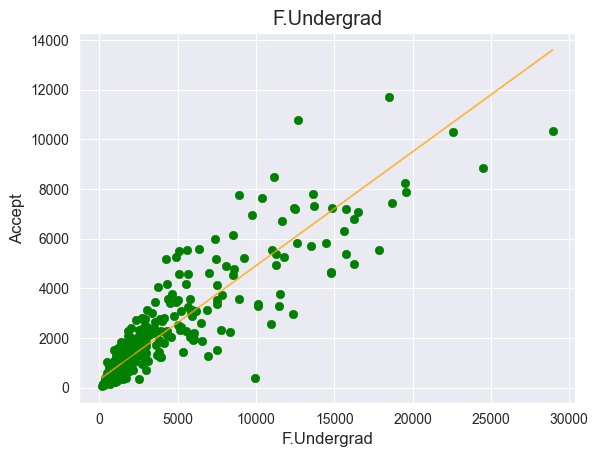

R2: -0.0018428297562884666
Intercept(s):  [1471.42005956]


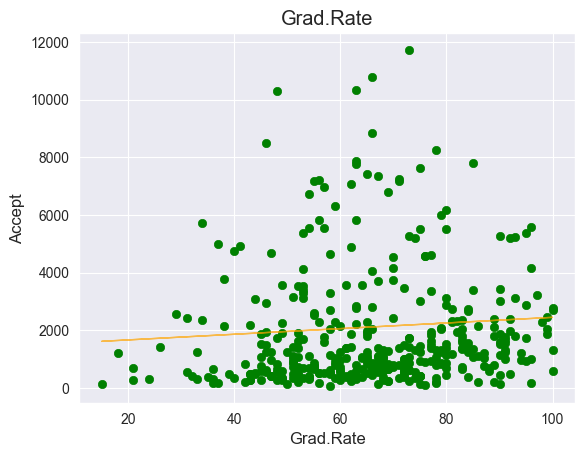

R2: -0.016505960921777252
Intercept(s):  [2527.51367146]


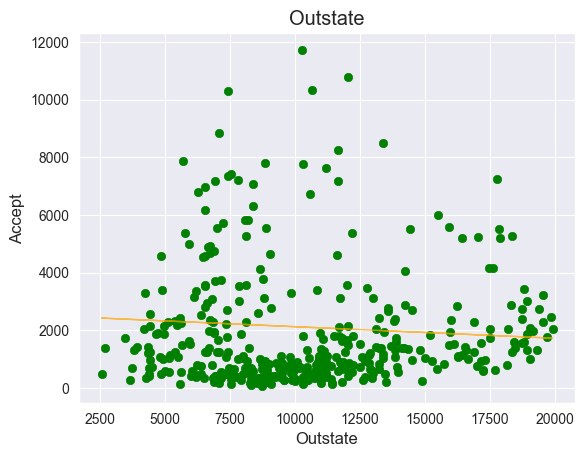

R2: 0.1892655087791948
Intercept(s):  [1415.90511587]


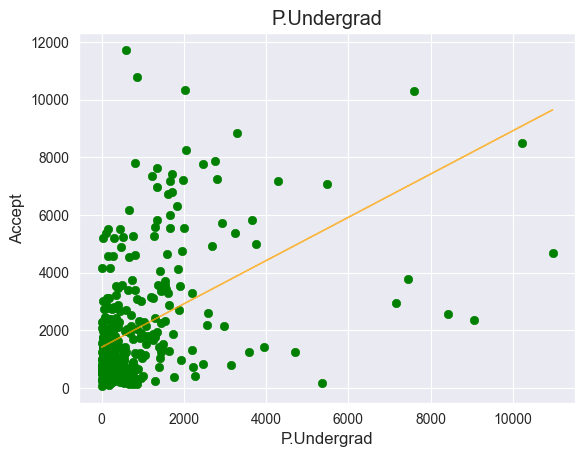

R2: 0.06358179784023554
Intercept(s):  [1289.56368567]


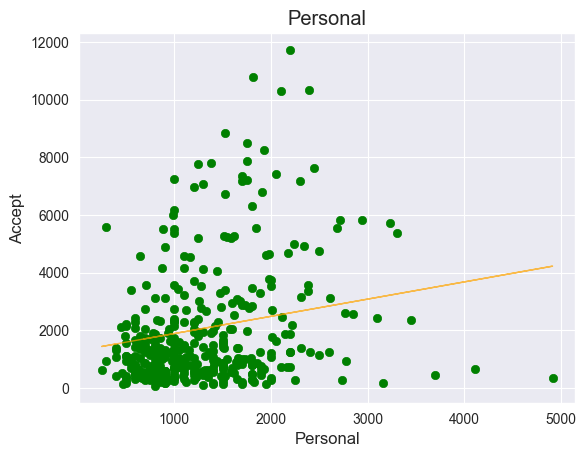

R2: 0.1299278474085892
Intercept(s):  [-1999.09868709]


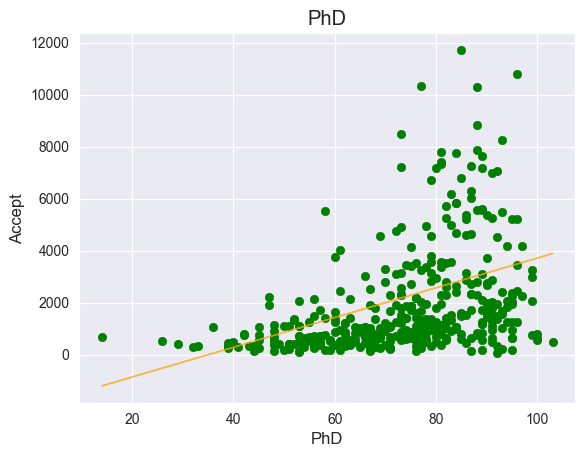

R2: 0.2831849786405939
Intercept(s):  [4100.78301887]


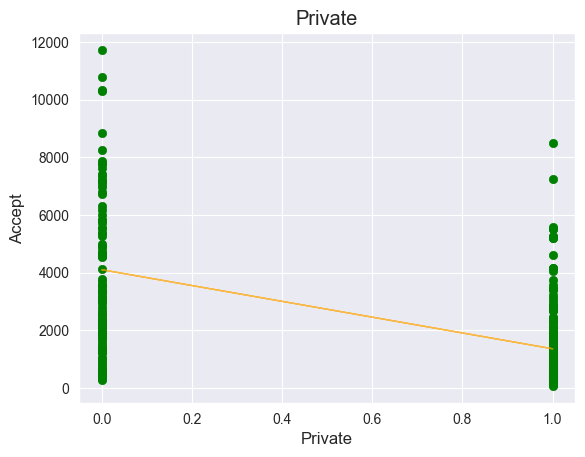

R2: 0.006705911943764242
Intercept(s):  [1325.8446564]


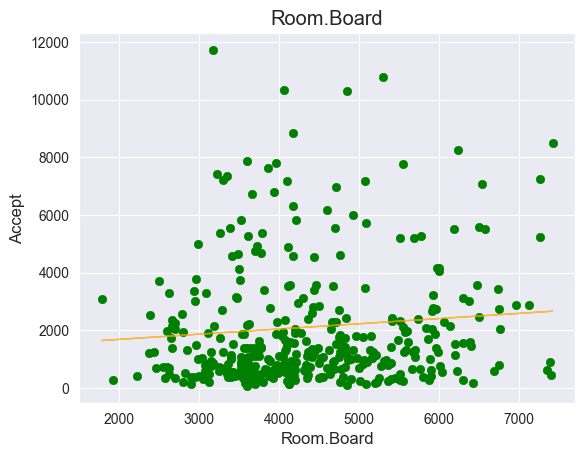

R2: 0.029008273305614285
Intercept(s):  [472.6645785]


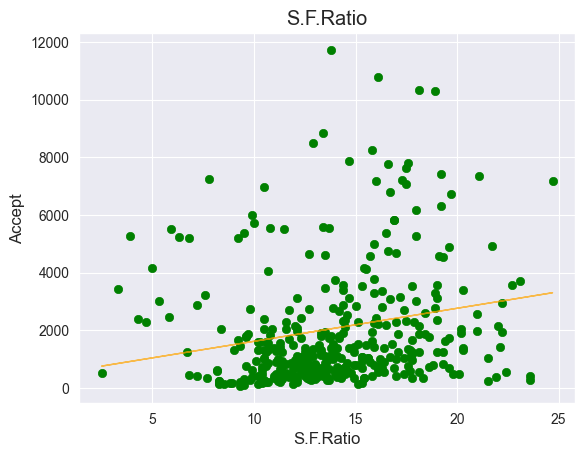

R2: 0.12145648810413845
Intercept(s):  [-2684.41131677]


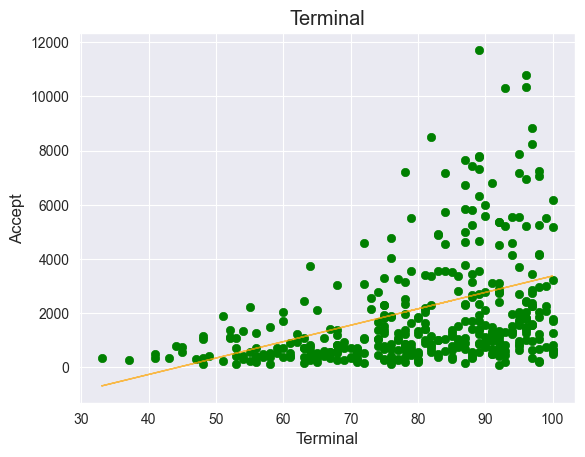

R2: 0.04074741646712543
Intercept(s):  [1358.81463729]


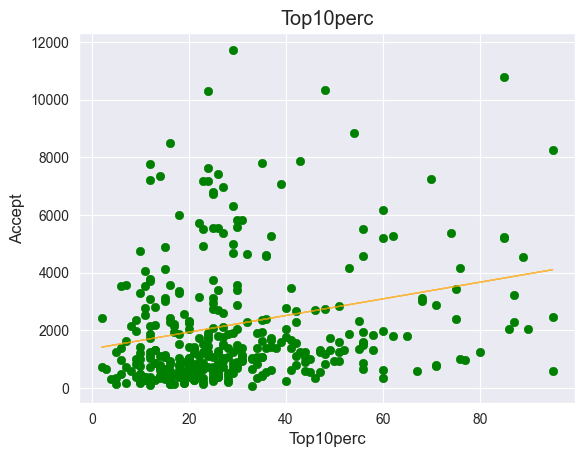

R2: 0.04407721634723938
Intercept(s):  [161.56125344]


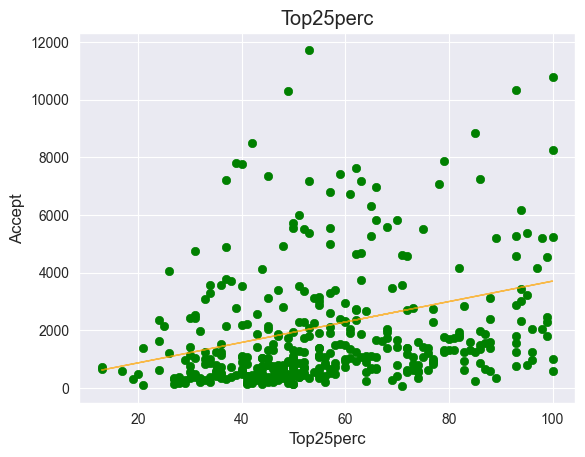

R2: 0.037428079900755584
Intercept(s):  [2744.21430429]


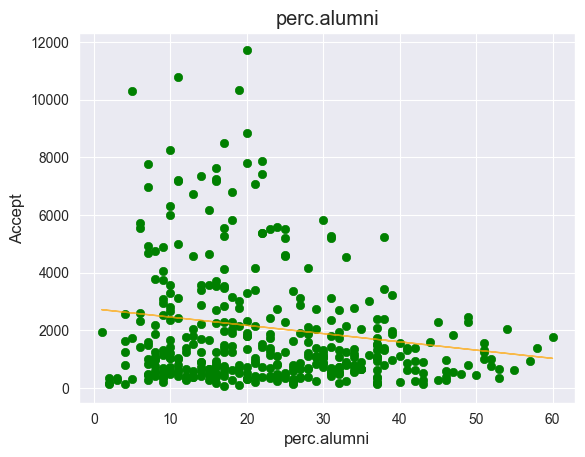

In [76]:
# Nhập code của bạn ở đây

def mo_hinh_hoa(d_model, d_X, d_y, title):
	d_X_train, d_X_test, d_y_train, d_y_test = train_test_split(d_X, d_y, test_size = 0.5, random_state = 7)
	d_X_train = np.array(d_X_train).reshape(-1, 1)
	d_X_test = np.array(d_X_test).reshape(-1, 1)
	d_y_train = np.array(d_y_train).reshape(-1, 1)
	d_y_test = np.array(d_y_test).reshape(-1, 1)
	d_model.fit(d_X_train, d_y_train)
	drawLine(d_model, d_X_test, d_y_test, title)


for element in X:
	model = LinearRegression()
	mo_hinh_hoa(model, X[element], y, element)


# Task 10: Mô hình hóa hồi quy tuyến đa biến số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở để dự đoán số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở từ bộ train và test

In [141]:
# Nhập code của bạn ở đây
# Room.Board Enroll
X_rb_er = college_df[["Enroll", "Room.Board"]]

X_rb_er_train, X_rb_er_test, y_rb_er_train, y_rb_er_test = train_test_split(X_rb_er, y, test_size = 0.3,
                                                                            random_state = 7)

X_rb_er_train, X_rb_er_test, y_rb_er_train, y_rb_er_test

(                              Enroll  Room.Board
 CollegeName                                     
 Illinois Wesleyan University     471        4090
 Point Park College               207        4830
 Colorado State University       2194        4180
 Spring Arbor College             181        3550
 University of Rochester         1243        6582
 ...                              ...         ...
 Taylor University                437        4000
 Saint Olaf College               745        3750
 Southwest State University       511        2750
 Fairfield University             781        6200
 Earlham College                  274        4056
 
 [543 rows x 2 columns],
                                          Enroll  Room.Board
 CollegeName                                                
 Westminster College                         377        3615
 North Central College                       308        7398
 Dominican College of Blauvelt               108        5500
 Baldwin-Wallace C

Điều chỉnh shape phù hợp với đầu vào của mô hình.

Lưu ý dữ liệu của chúng ta ở phần này là 2 đặc trưng, do đó đầu vào của mô hình đối với X sẽ là (m, 2)

In [142]:
# Nhập code của bạn ở đây
X_rb_er_train = np.array(X_rb_er_train).reshape(-1, 2)
X_rb_er_test = np.array(X_rb_er_test).reshape(-1, 2)
y_rb_er_train = np.array(y_rb_er_train).reshape(-1, 1)
y_rb_er_test = np.array(y_rb_er_test).reshape(-1, 1)

Xây dựng và huấn luyện mô hình

In [143]:

# Xây dựng mô hình hồi quy tuyến tính đa biến
model = LinearRegression()
# Huấn luyện mô hình
model.fit(X_rb_er_train, y_rb_er_train)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [144]:
# Nhập code của bạn ở đây
y_pred = model.predict(X_rb_er_test)
r2 = r2_score(y_rb_er_test, y_pred)
print(f"R² cho tập kiểm tra: {r2}")

R² cho tập kiểm tra: 0.8764371774214047


Trực quan mô hình với dữ liệu test

R2: 0.8764371774214047
Intercept(s):  [-1176.62848249]


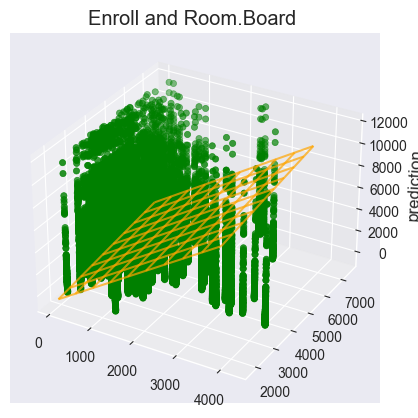

In [145]:
# Nhập code của bạn ở đây
drawPlane(model, X_rb_er_test, y_rb_er_test, "Enroll and Room.Board ")

# Task 11: Sử dụng hồi quy tuyến tính với toàn bộ đặc trưng để quan sát tác động của từng đặc trưng đến mục tiêu

Tạo một bản sao về dữ liệu train và test

In [16]:
# Nhập code của bạn ở đây
X_11 = X
y_11 = y

X_11_train, X_11_test, y_11_train, y_11_test = train_test_split(X_11, y_11, test_size = 0.3, random_state = 7)

X_11_train, X_11_test, y_11_train, y_11_test

(                              Apps  Books  Enroll  Expend  F.Undergrad  \
 CollegeName                                                              
 Illinois Wesleyan University  3050    400     471    9605         1818   
 Point Park College             875    400     207    7652         1173   
 Colorado State University     9478    470    2194    7850        15646   
 Spring Arbor College           372    385     181   10938         1501   
 University of Rochester       8766    500    1243   26037         5071   
 ...                            ...    ...     ...     ...          ...   
 Taylor University             1769    450     437    8294         1757   
 Saint Olaf College            2248    550     745   12502         2888   
 Southwest State University    1047    600     511    6591         2091   
 Fairfield University          4784    700     781   11220         2984   
 Earlham College               1358    600     274   14634         1028   
 
                       

In [17]:
len(X_11.columns)

17

Điều chỉnh shape phù hợp với đầu vào của mô hình.

Lưu ý rằng đầu vào của mô hình lúc này sẽ là (m, n).

In [19]:
# Nhập code của bạn ở đây
X_11_train = np.array(X_11_train).reshape(-1, len(X_11.columns))
X_11_test = np.array(X_11_test).reshape(-1, len(X_11.columns))
y_11_train = np.array(y_11_train).reshape(-1, 1)
y_11_test = np.array(y_11_test).reshape(-1, 1)

Trong hồi quy tuyến tính, đặc trưng có miền giá trị lớn hơn sẽ chiếm ưu thế hơn so với đặc trưng có miền giá trị nhỏ hơn. Để công bằng cho tất cả dặc trưng chúng ta sẽ áp dụng một phương pháp được gọi là co dãn đặc trưng

In [21]:
from sklearn.preprocessing import StandardScaler, Normalizer

# Nhập code của bạn ở đây
normal_X = Normalizer().fit_transform(X_11_train)
scaled_X = StandardScaler().fit_transform(X_11_train)
normal_X, scaled_X

Xây dựng và huấn luyện mô hình

In [22]:
# Nhập code của bạn ở đây
model = LinearRegression()
model.fit(X_11_train, y_11_train)


LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [23]:
# Nhập code của bạn ở đây
y_pred = model.predict(X_11_test)
r2 = r2_score(y_11_test, y_pred)
print(f"R² cho tập kiểm tra: {r2}")

R² cho tập kiểm tra: 0.919628527456307


Quan sát trong số đối với từng đặc trưng để kiểm tra xem đặc trưng nào có tác động mạnh hơn tới số lượng sinh viên được chấp nhận.

Đối chiếu trọng số của từng đặc trưng với ma trận trực quan để đối chiếu kết quả, nếu giá trị trong ma trận tương quan là dương lớn thì tham số đối với đặc trưng đó sẽ lớn và ngược lại.

Để hoàn thành được phần này, bạn hãy tham khảo và tìm ra cách lấy trọng số cho các đặc trưng từ [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) của Sklearn

In [24]:
# Nhập code của bạn ở đây
coefficients = model.coef_
intercept = model.intercept_
print(f"Trọng số của các đặc trưng: {coefficients}")
print(f"Tham số chặn: {intercept}")


Trọng số của các đặc trưng: [[ 4.38027672e-01 -3.22203565e-02  1.18800249e+00 -3.17280135e-02
  -3.00780366e-02 -1.55953045e+00  6.81453929e-02 -3.64976475e-02
  -2.81338965e-02  5.31293632e+00  1.92305843e+02 -1.12107624e-02
  -8.89992514e+00  1.12713347e+00 -2.97750242e+01  7.63994487e+00
  -5.08476715e+00]]
Tham số chặn: [-261.58214951]


**Câu hỏi: Đặc trưng nào có tác động mạnh nhất đến số lượng sinh viên được chấp nhận ?**

Trả lời (nhấn vào đây để trả lời):

**Câu hỏi: Đặc trưng nào có tác động ít nhất đến số lượng sinh viên được chấp nhận ?**

Trả lời (nhấn vào đây để trả lời):

# Task 12: Xây dựng mô hình hồi quy tuyến tính của riêng bạn

Tùy ý chọn đặc trưng và điều chỉnh siêu tham số

Yêu cầu: R2 score >= 0.9


In [ ]:
# Nhập code của bạn ở đây
your_model = ...

**Câu hỏi: Hãy giải thích quá trình lý do lựa chọn đặc trưng, các tham số điều chỉnh để đạt được R2 score >= 0.9**

Trả lời (nhấn vào đây để trả lời):

# Task 13: Sử dụng hồi quy Lasso để chọn ra đặc trưng tốt nhất để dự đoán số lượng sinh viên được chấp nhận.

Hồi quy Lasso là hồi quy tuyến tính đặc biệt được tinh chỉnh để có thể đưa các tham số của các đặc trưng không quan trọng tiến về 0 và còn lại các đặc trưng quan trọng.

Alpha càng lớn, tham số của các đặc trưng không quan trọng càng nhỏ và tiến về 0 nhanh.

Yêu cầu: Tìm giá trị alpha sao cho mô hình đạt R2 score >= 0.92

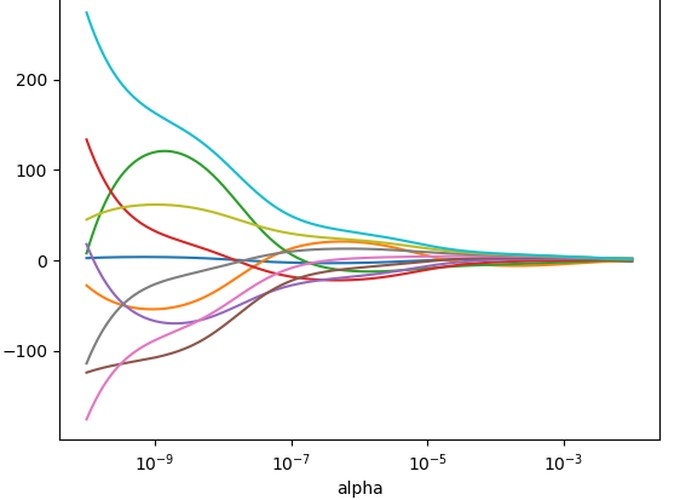

In [ ]:


# Nhập code của bạn ở đây


Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [ ]:
# Nhập code của bạn ở đây


0.9215284499424126

Quan sát tham số với từng đặc trưng để kiểm tra xem đặc trưng nào bị loại bỏ bằng phương pháp Lasso

In [ ]:
# Nhập code của bạn ở đây


**Câu hỏi: Đặc trưng nào bị loại bỏ trong hồi quy Lasso ?**

Trả lời (nhấn vào đây để trả lời):